In [4]:
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def SaveDataToDF(f):
    myData = []
    myDataNames = []
    def saveDat(item):
        if 'Data' in str(f[item].id):
            data2use = f[item][()]
            if data2use.ndim == 2:#some groups have multiple columns and this messes up the translation to a df at the end of this function
                [a,b] = data2use.shape
                for col in np.arange(0,b):
                    myData.append(data2use[:,col])
                    dataName = (f[item].name).split('/')[-1] + str(col)
                    myDataNames.append(dataName)
            else:
                myData.append(f[item][()])
                dataName = (f[item].name).split('/')[-1]
                myDataNames.append(dataName)
        
    f.visit(saveDat)
    allData = pd.DataFrame(myData).T
    allData.columns = myDataNames
    f.close()
    return allData
archived_path = '/home/group/CA1Results/all_data_001'

# Single Cell Model Voltage

In [ ]:
import numpy as np
from neuron import h
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy.signal import find_peaks
import h5py
#do not rerun
h.load_file('stdrun.hoc')
h.nrn_load_dll(os.path.join("biophys_components","mechanisms","modfiles","x86_64",".libs","libnrnmech.so"))
fileList = ['class_pyramidalcell.hoc','class_axoaxoniccell.hoc', 'class_pvbasketcell.hoc', 'class_olmcell.hoc']
for item in fileList:
    h.load_file(os.path.join("biophys_components","templates",item))
callNames = ["h." + fileList[i].split('_')[1].split('.')[0] + "()" for i in range(len(fileList))]
callNames.sort()
callNames

In [ ]:
tstop = 500
iclamp_amp = 0.6

Cell1 = h.olmcell()

iclamp = h.IClamp(Cell1.soma[0](0.5))
iclamp.delay = 100
iclamp.dur = 78
iclamp.amp =iclamp_amp


vCell1 = h.Vector().record(Cell1.soma[0](0.5)._ref_v)


h.dt=0.1
h.L = 20
h.finitialize(-63)
h.continuerun(tstop)

vCell1 = np.array(vCell1)


time = np.linspace(0,tstop,int(tstop/h.dt )+1)#+1 for some reason
plt.plot(time,vCell1,label=str(Cell1).split('cell')[0])
plt.legend()
plt.show()

# Raster

In [ ]:
f = h5py.File(os.path.join(archived_path,'network','biophysical_nodes.h5'), 'r')
nodesDF = SaveDataToDF(f)
f = h5py.File(os.path.join(archived_path,'output','spikes.h5'), 'r')
spikesDF = SaveDataToDF(f) 


cellLocations = pd.read_csv('cell_locations.csv')#this was for the old build, i'm just reading it instead of writing the list coz lazy
idNames = np.unique(nodesDF['node_type_id'])
cellNames = np.unique(cellLocations['Cell type'])
array = cellLocations['Cell type']
idxs = np.unique(cellLocations['Cell type'],return_index=True)[1]
cellNames = [array[index] for index in sorted(idxs)]#use the names in the order in which the id's appear

nodesDF = nodesDF.replace({'node_type_id':idNames},{'node_type_id':cellNames})



namesList = []
for i in range(len(spikesDF['node_ids'])):
    namesList.append(nodesDF['node_type_id'][spikesDF['node_ids'][i]])
spikesDFM = pd.concat([spikesDF,pd.Series(namesList)],axis=1)
spikesDFM.columns = ['node_ids','timestamps','node_type_id']

plt.figure(figsize=(20,10))
groups = spikesDFM.groupby('node_type_id')
for name, group in groups:
    plt.plot(group.timestamps, group.node_ids,marker='o',linestyle="",markersize=4, label=name)
plt.legend(loc='upper right')
plt.xlim([100,1500])
#plt.hlines(counts,xmin=0, xmax = max(spikesDFM['timestamps']))
#plt.savefig('raster.png',dpi=400)
plt.show()

In [ ]:
spikesDFM.to_csv('spikesDFM.csv')

# voltages of cells in network by ID

In [19]:
f = h5py.File(os.path.join(archived_path,"output",'v_report.h5'), 'r')
#f.visit(print)
node_ids = f['report/biophysical/mapping/node_ids'][()]
voltages = f['report/biophysical/data'][()]
time = f['report/biophysical/mapping/time'][()]
f.close()
timesteps = np.arange(time[0],time[1],float(time[2]))

report
report/biophysical
report/biophysical/data
report/biophysical/mapping
report/biophysical/mapping/element_ids
report/biophysical/mapping/element_pos
report/biophysical/mapping/index_pointer
report/biophysical/mapping/node_ids
report/biophysical/mapping/time


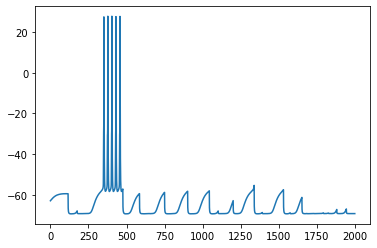

In [44]:
ID = 13666
start,end = 0,20000
plt.plot(timesteps[start:end],voltages[start:end,np.where(node_ids == ID)[0][0]])
plt.savefig('voltage.png',dpi=300)
plt.show()

# ecp

In [45]:
archived_path = '/home/group/CA1Results/all_data_001'
f = h5py.File(os.path.join(archived_path,"output",'ecp.h5'), 'r')
data = f['ecp/data'][()]
time = f['ecp/time'][()]
f.close()

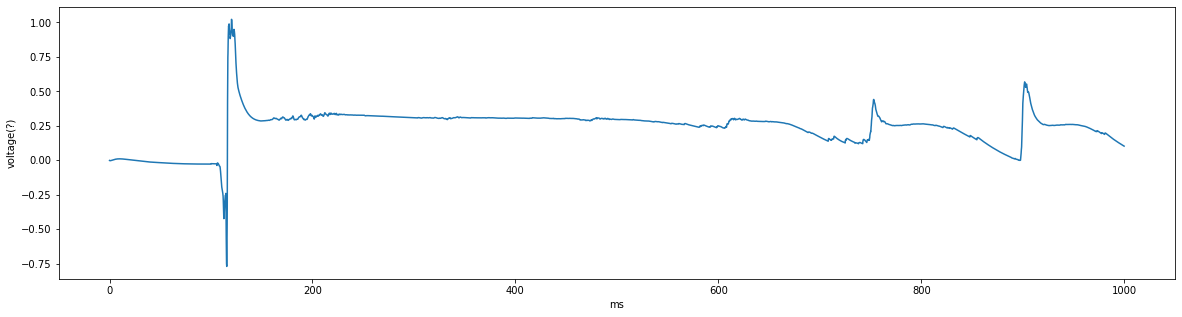

In [101]:
start,end = 0, 10000
plt.figure(figsize=(20,5))
plt.plot(np.arange(time[0],time[1],time[2])[start:end],data[start:end,10])
#plt.xlim([175,200])
plt.xlabel('ms')
#plt.ylim([0,0.1])
plt.ylabel('voltage(?)')
#plt.savefig('ecp.png',dpi=400)
plt.show()

In [59]:
from scipy import signal
from scipy.signal import hilbert
import numpy as np

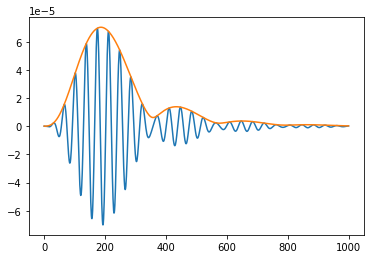

In [74]:
start,end = 0, 100000
sos = signal.butter(4, [250,300], btype='bandpass', fs=10000, output='sos',analog=False)

filtered = signal.sosfilt(sos, data[start:end,0])
plt.plot(filtered[:1000])
analytical_signal = hilbert(filtered[:1000])
amplitude_envelope = np.abs(analytical_signal)
plt.plot(amplitude_envelope)
plt.show()

In [175]:
data.shape

(100000, 13)

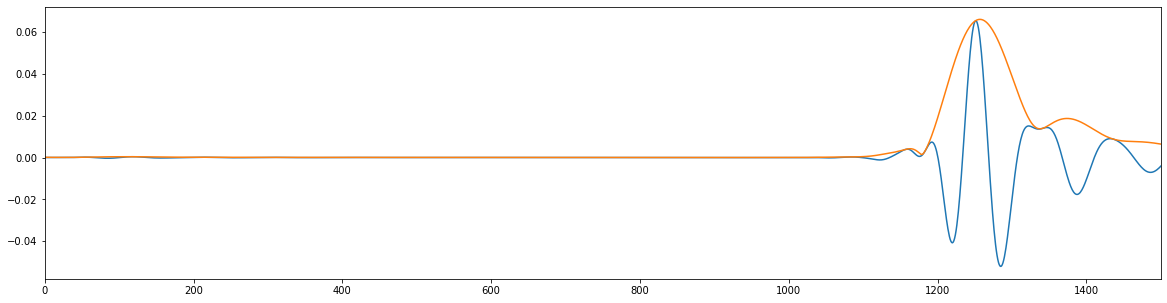

In [189]:
archived_path = '/home/group/CA1Results/all_data_001'
f = h5py.File(os.path.join(archived_path,"output",'ecp.h5'), 'r')
data = f['ecp/data'][()]
time = f['ecp/time'][()]
f.close()

start,end = 0, 10000
Fs = 10000
sos = signal.butter(4, [int(10/(1000/Fs)),int(20/(1000/Fs))], btype='bandpass', fs=10000, output='sos',analog=False)

filtered = signal.sosfilt(sos, data[start:end,0])

plt.figure(figsize=(20,5))
plt.plot(filtered)
analytical_signal = hilbert(filtered)
amplitude_envelope = np.abs(analytical_signal)
plt.plot(amplitude_envelope)

plt.xlim([0,1500])
#plt.hlines(counts,xmin=0, xmax = max(spikesDFM['timestamps']))
#plt.savefig('raster.png',dpi=400)
plt.show()


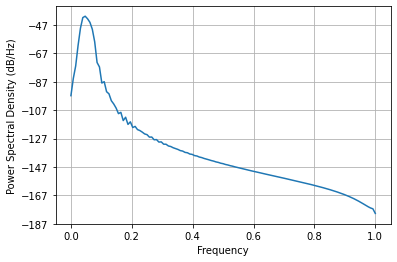

In [103]:
plt.psd(filtered)
plt.show()

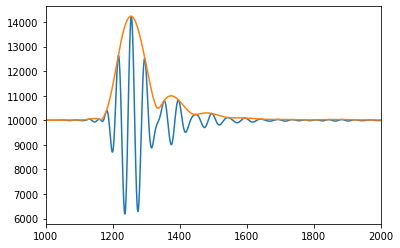

In [165]:
from scipy import signal
from scipy.signal import hilbert
archived_path = '/home/group/CA1Results/all_data_001'
f = h5py.File(os.path.join(archived_path,"output",'spikes.h5'), 'r')


nids = f['spikes']['biophysical']['node_ids'][:]
ts =f['spikes']['biophysical']['timestamps'][:]
f.close()

#plt.plot(ts,nids,'.',color='k',alpha=0.4)


f = h5py.File(os.path.join(archived_path,"output",'ecp.h5'), 'r')
data = f['ecp/data'][()]
time = f['ecp/time'][()]
f.close()

# start,end = 0, 10000
# Fs = 10000
# b,a = signal.butter(4, [int(120/(1000/Fs)),int(220/(1000/Fs))], btype='bandpass', fs=Fs, analog=False)

# filtered = signal.filtfilt(b, a, data[start:end,0])
start,end = 0, 10000
sos = signal.butter(4, [200,300], btype='bandpass', fs=10000, output='sos',analog=False)

filtered = signal.sosfilt(sos, data[start:end,0])
#plt.plot(data[start:end,-1])
#plt.twinx()
plt.plot(filtered*100000+10000)
analytical_signal = hilbert(filtered)
amplitude_envelope = np.abs(analytical_signal)
plt.plot(amplitude_envelope*100000+10000)
plt.xlim(1000,2000)
plt.show()

In [160]:
archived_path = '/home/group/CA1Results/all_data_001'

f = h5py.File(os.path.join(archived_path,"output",'spikes.h5'), 'r')
f.visit(print)

spikes
spikes/biophysical
spikes/biophysical/node_ids
spikes/biophysical/timestamps


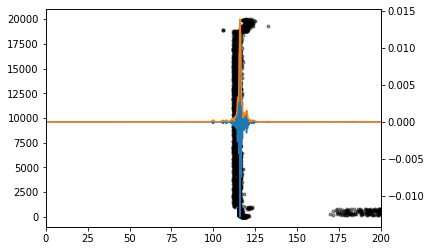

In [207]:
from scipy import signal
from scipy.signal import hilbert

archived_path = '/home/group/CA1Results/all_data_001'

f = h5py.File(os.path.join(archived_path,"output",'spikes.h5'), 'r')
nids = f['spikes']['biophysical']['node_ids'][()]
ts =f['spikes']['biophysical']['timestamps'][()]
f.close()

f = h5py.File(os.path.join(archived_path,"output",'ecp.h5'), 'r')
data = f['ecp/data'][()]
time = f['ecp/time'][()]
f.close()
times = np.arange(time[0],time[1],time[2])[start:end]
plt.plot(ts,nids,'.',color='k',alpha=0.4)

start,end = 0, 10000
Fs = 10000
b,a = signal.butter(4, [int(120/(1000/Fs)),int(220/(1000/Fs))], btype='bandpass', fs=Fs, analog=False)

filtered = signal.filtfilt(b, a, data[start:end,0])

#plt.plot(data[start:end,-1])
plt.twinx()
plt.plot(times,filtered)
analytical_signal = hilbert(filtered)
amplitude_envelope = np.abs(analytical_signal)
plt.plot(times,amplitude_envelope)
plt.xlim(0,200)
plt.show()

In [150]:
int(220/(1000/Fs))

2200